In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-vision-showdown-procom-25/sample_submission.csv
/kaggle/input/deep-vision-showdown-procom-25/train.csv
/kaggle/input/deep-vision-showdown-procom-25/test_set/a7cb1fff3b.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/3d17d9c95c.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/1ccf222fde.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/eb1642aebc.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/982841b3e6.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/81c5ff3f3f.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/15adc2c52d.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/74dc0638ee.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/18cb18b85b.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/95f38a4e55.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/369e3f3670.tif
/kaggle/input/deep-vision-showdown-procom-25/test_set/554534ee5c.tif
/kaggle/input/deep-vision-showdown-procom-25/test_

In [2]:
!pip install segmentation-models-pytorch
!pip install albumentations


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 2.0 MB/s eta 0:00:00ta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ef330f4e35221a294c26ef3f7e6b6b9c889bfee1a84ec6e563ff7a4a0dd0ee2f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=f7b91ba276fdd71281556567dfa8e521d67ed82ca7ba27cb528c8c8fe14f5a05
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
# -------------------------
# 🛠️ Import Libraries
# -------------------------
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# -------------------------
# 🚀 Device Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# -------------------------
# 🛠️ RLE Decode Function
# -------------------------
def rle_decode(mask_rle, shape):
    """
    Decode RLE (Run-Length Encoding) mask.
    Args:
        mask_rle (str): Encoded mask in RLE format.
        shape (tuple): (height, width) of the expected output mask.
    Returns:
        np.array: Decoded binary mask.
    """
    if pd.isna(mask_rle):  # Handle missing masks
        return np.zeros(shape, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1  # Convert to 0-based indexing
    ends = starts + lengths
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for start, end in zip(starts, ends):
        mask[start:end] = 1

    return mask.reshape(shape)

In [7]:
# -------------------------
# 📌 Dataset Class
# -------------------------
class UltrasoundDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['image_id']
        mask_rle = self.df.iloc[idx]['pixels']
    
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    
        if img is None:
            raise FileNotFoundError(f"Image {img_path} not found!")
    
        mask = rle_decode(mask_rle, img.shape)  
    
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32)
    
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]
    
        mask = mask.unsqueeze(0)  # 🚀 Fix: Ensure mask shape is [1, H, W]
    
        return img, mask


In [8]:
# -------------------------
# 🔄 Data Augmentation
# -------------------------
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

In [9]:
# -------------------------
# 🚀 Load Dataset
# -------------------------
train_df = pd.read_csv('/kaggle/input/deep-vision-showdown-procom-25/train.csv')
train_img_dir = "/kaggle/input/deep-vision-showdown-procom-25/train_set"

train_dataset = UltrasoundDataset(train_df, train_img_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Verify data
img, mask = train_dataset[0]
print(f"Image shape: {img.shape}, Mask shape: {mask.shape}, Unique Mask Values: {torch.unique(mask)}")


Image shape: torch.Size([1, 256, 256]), Mask shape: torch.Size([1, 256, 256]), Unique Mask Values: tensor([0., 1.])


In [10]:
# -------------------------
# 🏗️ Model Definition 
# -------------------------
model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1  
).to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 170MB/s]


In [11]:
# -------------------------
# 🩸 Loss Function 
# -------------------------
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce_loss = nn.BCEWithLogitsLoss()

    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)  
        intersection = (pred * target).sum(dim=(1, 2, 3))
        dice = (2. * intersection + smooth) / (pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + smooth)
        return 1 - dice.mean()  

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)  
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice + self.bce_weight * bce

loss_fn = CombinedLoss().to(device)


In [12]:
# -------------------------
# 🎯 Dice Score Function 
# -------------------------
def dice_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred)  
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice.item()

In [13]:
# -------------------------
# 🔥 Training Loop
# -------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

scaler = torch.amp.GradScaler()
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    dice_total = 0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=True):
            pred = model(images)
            loss = loss_fn(pred, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        dice_total += dice_score(pred, masks)

    avg_loss = epoch_loss / len(train_loader)
    avg_dice = dice_total / len(train_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Dice Score: {avg_dice:.4f}")

    scheduler.step(avg_loss)  
    torch.save(model.state_dict(), f"V3_unet_epoch_{epoch+1}.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Loss: 0.6052 | Dice Score: 0.0302
Epoch 2/100 | Loss: 0.5119 | Dice Score: 0.1517
Epoch 3/100 | Loss: 0.4845 | Dice Score: 0.2427
Epoch 4/100 | Loss: 0.4728 | Dice Score: 0.2693
Epoch 5/100 | Loss: 0.4617 | Dice Score: 0.3039
Epoch 6/100 | Loss: 0.4256 | Dice Score: 0.4178
Epoch 7/100 | Loss: 0.4032 | Dice Score: 0.4841
Epoch 8/100 | Loss: 0.3910 | Dice Score: 0.5235
Epoch 9/100 | Loss: 0.3837 | Dice Score: 0.5532
Epoch 10/100 | Loss: 0.3770 | Dice Score: 0.5800
Epoch 11/100 | Loss: 0.3727 | Dice Score: 0.5916
Epoch 12/100 | Loss: 0.3692 | Dice Score: 0.5984
Epoch 13/100 | Loss: 0.3661 | Dice Score: 0.6194
Epoch 14/100 | Loss: 0.3629 | Dice Score: 0.6296
Epoch 15/100 | Loss: 0.3604 | Dice Score: 0.6389
Epoch 16/100 | Loss: 0.3581 | Dice Score: 0.6594
Epoch 17/100 | Loss: 0.3561 | Dice Score: 0.6607
Epoch 18/100 | Loss: 0.3543 | Dice Score: 0.6782
Epoch 19/100 | Loss: 0.3521 | Dice Score: 0.6856
Epoch 20/100 | Loss: 0.3503 | Dice Score: 0.6950
Epoch 21/100 | Loss: 0.3494 |

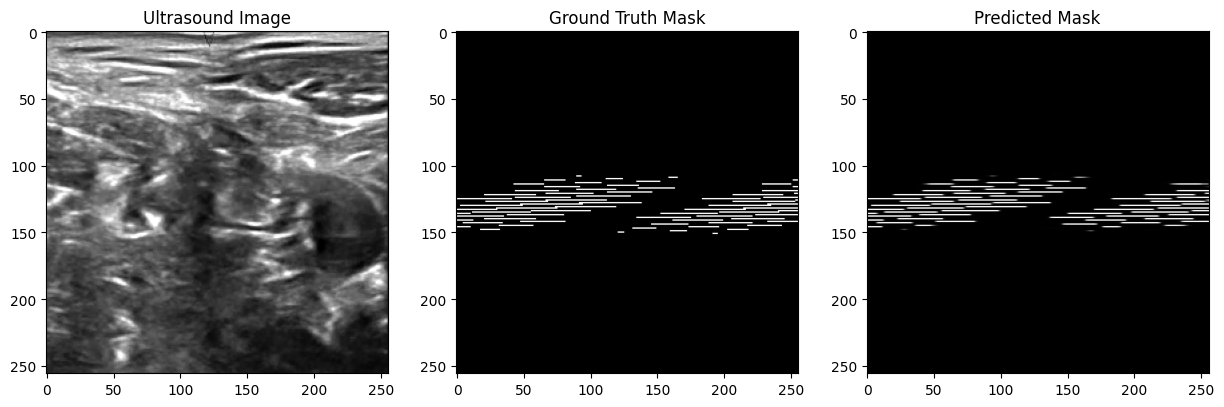

In [41]:
# -------------------------
# 🖼️ Prediction & Visualization
# -------------------------
def show_predictions(idx):
    img, mask = train_dataset[idx]
    img = img.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(img)
        pred = torch.sigmoid(pred).cpu().squeeze(0).squeeze(0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    ax[0].set_title("Ultrasound Image")

    ax[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(pred.numpy(), cmap='gray')
    ax[2].set_title("Predicted Mask")

    plt.show()

show_predictions(127)

In [32]:
# Generating CSV file for Test data

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# -------------------------
# 🚀 Device Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# 🔄 Run-Length Encoding (RLE) Function
# -------------------------
def rle_encode(mask):
    """
    Encode a binary mask using Run-Length Encoding (RLE).
    Args:
        mask (np.array): Binary mask (0s and 1s).
    Returns:
        str: RLE encoded string.
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])  # Add padding to detect changes
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

# -------------------------
# 🎯 Load the Trained Model
# -------------------------
model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=1,
    classes=1
).to(device)

# Load trained weights
model.load_state_dict(torch.load("V3_unet_epoch_100.pth", map_location=device))  # Change to latest model
model.eval()

# -------------------------
# 📌 Image Transformation
# -------------------------
transform = A.Compose([
    A.PadIfNeeded(min_height=448, min_width=608, border_mode=cv2.BORDER_CONSTANT, value=0),  
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

# -------------------------
# 📂 Define Paths
# -------------------------
test_img_dir = "/kaggle/input/deep-vision-showdown-procom-25/test_set"
output_csv_path = "predictions.csv"

# -------------------------
# 📌 Predict and Save Results
# -------------------------
results = []

for image_name in tqdm(os.listdir(test_img_dir)):
    image_path = os.path.join(test_img_dir, image_name)

    if not image_name.endswith((".png", ".jpg", ".jpeg", ".tif")):  # Skip non-image files
        continue

    # Load image as grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error loading image: {image_name}")
        continue

    # Normalize
    img = img.astype(np.float32) / 255.0
    
    # Apply transformations correctly
    transformed = transform(image=img)  # Pass as a dictionary
    img = transformed["image"]  # Extract transformed image
    
    # Convert to tensor and add batch dimension
    img = img.unsqueeze(0).to(device)

    # Predict mask
    with torch.no_grad():
        pred = model(img)
        pred = torch.sigmoid(pred).cpu().squeeze().numpy()

    # Convert probability mask to binary mask
    binary_mask = (pred > 0.5).astype(np.uint8)

    # Encode mask using RLE
    mask_rle = rle_encode(binary_mask)

    # Store result
    results.append({
        "image_id": image_name.replace(".tif", ""),
        "pixels": mask_rle
    })

# Save predictions to CSV
df = pd.DataFrame(results)
df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")


<ipython-input-32-8f41dea97fdf>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("V3_unet_epoch_100.pth", map_location=device))  # Change t

Using device: cuda


100%|██████████| 1691/1691 [00:56<00:00, 29.97it/s]

Predictions saved to predictions.csv


In [34]:
import os

file_path = "/kaggle/working/predictions.csv"
if os.path.exists(file_path):
    print("File exists:", file_path)
else:
    print("File not found!")


File exists: /kaggle/working/predictions.csv


In [36]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to decode RLE to a binary mask
def rle_decode(mask_rle, shape):
    """
    Decode RLE-encoded mask into a binary mask.
    """
    if pd.isna(mask_rle) or mask_rle == "":  # Handle missing or empty masks
        return np.zeros(shape, dtype=np.uint8)
    
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    ends = [start + length for start, length in zip(starts, lengths)]
    
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1
    return mask.reshape(shape)

# Load ground truth
ground_truth_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv")  # Your file should contain "image_id" and "pixels"
predictions_df = pd.read_csv("/kaggle/working/predictions.csv")  # Already generated from your model

# Initialize lists for evaluation
y_true = []
y_pred = []

for _, row in predictions_df.iterrows():
    image_id = row["image_id"]
    pred_rle = row["pixels"]

    # Get ground truth mask (handle missing values)
    gt_rle = ground_truth_df.loc[ground_truth_df["image_id"] == image_id, "pixels"].values
    if len(gt_rle) == 0:  # If no ground truth exists, skip
        continue
    gt_rle = gt_rle[0]

    # Decode both masks
    gt_mask = rle_decode(gt_rle, shape=(448, 608))  # Adjust shape based on your dataset
    pred_mask = rle_decode(pred_rle, shape=(448, 608))

    # Flatten for comparison
    y_true.extend(gt_mask.flatten())
    y_pred.extend(pred_mask.flatten())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Background", "Lesion"])
print(report)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Lesion"], yticklabels=["Background", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the classification report to a file
with open("/kaggle/working/classification_report.txt", "w") as f:
    f.write(report)

print("Classification report saved as /kaggle/working/classification_report.txt")


Processing images: 100%|██████████| 1691/1691 [00:01<00:00, 905.17it/s]


              precision    recall  f1-score   support

  Background       1.00      1.00      1.00 459777811
      Lesion       0.00      0.00      0.00      6381

    accuracy                           1.00 459784192
   macro avg       0.50      0.50      0.50 459784192
weighted avg       1.00      1.00      1.00 459784192

Accuracy: 0.9999


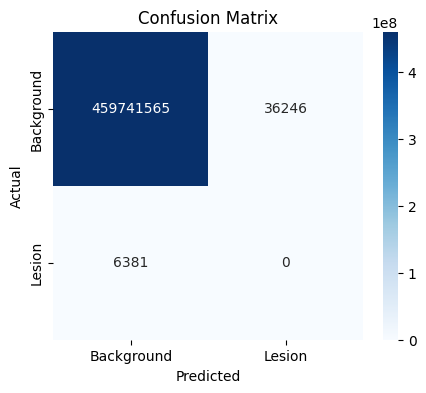

✅ Classification report saved as /kaggle/working/classification_report.txt


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar for better tracking

# Function to decode RLE to a binary mask
def rle_decode(mask_rle, shape):
    """
    Decode RLE-encoded mask into a binary mask.
    """
    if pd.isna(mask_rle) or mask_rle == "":  # Handle missing or empty masks
        return np.zeros(shape, dtype=np.uint8)
    
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    ends = [start + length for start, length in zip(starts, lengths)]
    
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1
    return mask.reshape(shape)

# Load ground truth
ground_truth_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv")  # Your file should contain "image_id" and "pixels"
predictions_df = pd.read_csv("/kaggle/working/predictions.csv")  # Already generated from your model

# Reduce dataset size for testing (optional)
# predictions_df = predictions_df.head(100)  # Uncomment for faster testing

# Initialize lists for evaluation
y_true = []
y_pred = []

# Loop with progress bar
for _, row in tqdm(predictions_df.iterrows(), total=len(predictions_df), desc="Processing images"):
    image_id = row["image_id"]
    pred_rle = row["pixels"]

    # Get ground truth mask (handle missing values)
    gt_rle = ground_truth_df.loc[ground_truth_df["image_id"] == image_id, "pixels"].values
    if len(gt_rle) == 0:  # If no ground truth exists, skip
        continue
    gt_rle = gt_rle[0]

    # Decode both masks
    gt_mask = rle_decode(gt_rle, shape=(448, 608))  # Adjust shape based on your dataset
    pred_mask = rle_decode(pred_rle, shape=(448, 608))

    # Flatten for comparison
    y_true.append(gt_mask.flatten())  # Store as NumPy arrays
    y_pred.append(pred_mask.flatten())

# Convert to NumPy arrays for faster computation
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Background", "Lesion"])
print(report)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Lesion"], yticklabels=["Background", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the classification report to a file
with open("/kaggle/working/classification_report.txt", "w") as f:
    f.write(report)

print("✅ Classification report saved as /kaggle/working/classification_report.txt")
